In [1]:
#pip install num2words
!pip install unidecode

     |████████████████████████████████| 245kB 8.6MB/s 


In [2]:
import os
import pandas as pd
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords, wordnet
from bs4 import BeautifulSoup
#from lxml import etree
from collections import defaultdict, Counter
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import metrics, cluster, preprocessing
import matplotlib.pyplot as plt
import csv
import numpy as np
import random
import seaborn as sns
%matplotlib inline
from sklearn import manifold, decomposition
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble \
import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC, SVC
import timeit
import itertools
import unidecode

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [3]:
from google.colab import drive
drive.mount('/content/drive') 
import sys
sys.path.append("/content/drive/My Drive/Colab Notebooks")
import os 
os.chdir('/content/drive/My Drive/Colab Notebooks/P6_Catégorisez automatiquement des questions')

Mounted at /content/drive


In [4]:
SEP = {'Title' : ' ', 'Body' : ' ', 'Tags' : '><'}
TOP = 50

def conv_html(col):
    """
    Fonction de convertion de html en chaine standard
    """

    html = BeautifulSoup(col, 'html.parser')
    # Delete url strings
    for t in html.find_all('a'):
        t.replace_with('')
    # Delete code blocks
    for t in html.find_all('pre'):
        t.replace_with('')
    
    return html.get_text(' ', strip=True)

def clean_field(col, tknzr, sw, lmtzr, stmr):
    """
    Fonction de tokenisation du contenu dont regex \w+, 
    suppression des stopwords, lemmatisation et racinisation
    """

    temp = tknzr.tokenize(unidecode.unidecode(col).lower())
    return ' '.join(stmr.stem(lmtzr.lemmatize(w, get_wordnet_pos(w))) \
                    for w in temp if w not in sw and not w.isdigit())

def get_wordnet_pos(word):
    """
    Map POS tag to first character lemmatize() accepts
    """

    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def recap_cols(df, cols):
    """
    Fonction de dénombrement du contenu des listes des colonnes (cols) de df
    """

    print('='*50, '\nDénombrenent des mots')
    
    for col in cols:
        #liste = list(itertools.chain.from_iterable(df[col].values))
        freq[col] = Counter(' '.join(df[col].values).split()).most_common()
        print('\t{:6s} : {:>7d} dont {:>6d} distincts'.\
                format(col, sum(dict(freq[col]).values()), len(freq[col])))
    print('='*50)
        
    return freq

# Chargement

In [5]:
freq = defaultdict()

train = pd.read_csv("db_StackOverflow.csv", header=0, encoding='utf-8', \
                    delimiter=',', quotechar='"', index_col=0, )
train.rename_axis(None, inplace=True)
train = train.apply(lambda x: x.astype(str).str.lower())
cols = train.columns

print(train.info())

freq = recap_cols(train, cols) 

train.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 169828 to 1669645
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Title   50000 non-null  object
 1   Body    50000 non-null  object
 2   Tags    50000 non-null  object
dtypes: object(3)
memory usage: 1.5+ MB
None
Dénombrenent des mots
	Title  :  428719 dont  37241 distincts
	Body   : 6055132 dont 561841 distincts
	Tags   :   50000 dont  37101 distincts


,Title,Body,Tags
169828,what are the real benefits of visual studio te...,<p>interested if anyone has used vsts database...,<sql-server><database-tools>
431644,how can i hook into the current formsauthentic...,<p>i've got an httpmodule in my application th...,<asp.net><events><forms-authentication><httpmo...
1450121,is there any sync algorithm/reference availabl...,<p>i'm planning to write a program to sync a f...,<algorithm><synchronization>
426609,how to assign profile values?,"<p>i don't know what i am missing, but i added...",<asp.net><asp.net-mvc><asp.net-membership><pro...
14646,"how to add ""project description"" in fogbugz?",<p>when i create a new project (or even when i...,<fogbugz>


# Nettoyage du dataframe

In [6]:
# Pour étiqueter les tags
lbl = LabelEncoder()

# Stopwords nltk 
std_sw = set(nltk.corpus.stopwords.words('english')) 

# Extra stopwords = radicaux qui ne me semblent pas discriminants 
extra_sw = ('use', 'get', 'like', 'way', 'creat', 'would', 'want', 'need',\
            'know', 'could', 'x', 'xx', 'xyz', 'aa', 'xxx', 'z', 'yyyi', 'wont',\
            'aaa', 'aaaaaa', 'aabbc', 'aandb', 'aarrggbb')

my_sw = std_sw.union(extra_sw)

tokenizer = nltk.RegexpTokenizer(r'\w+')
lemmatizer = WordNetLemmatizer() 
stemmer = PorterStemmer()

print('='*50)

for col in ['Title', 'Body']:
    if col == 'Body':
        print('Conversion html de "{}" '.format(col), end='')
        start_time = timeit.default_timer()

        # Convertion du html en chaine standard 
        train[col] = train[col].apply(conv_html)

        elapsed = timeit.default_timer() - start_time
        print('-> OK en {:.3} sec'.format(elapsed))

    print('Nettoyage/lemmatisation de "{}" '.format(col), end='')
    start_time = timeit.default_timer()

    # Tokenisation et suppression des stopwords
    train[col] = train[col].apply(clean_field, tknzr=tokenizer, \
                                  sw=std_sw, lmtzr=lemmatizer, stmr=stemmer)

    # Suppression des radicaux qui ne me semblent pas discriminants (ex. use, ...)
    train[col] = train[col].apply(lambda x: ' '.join([w for w in x.split() \
                                                      if w not in extra_sw]))

    elapsed = timeit.default_timer() - start_time
    print('-> OK en {:.3} sec'.format(elapsed))

print('Traitement des tags ', end='')
start_time = timeit.default_timer()

# Epurage et tri des tags
train['Tags'] = train['Tags'].apply(lambda x: ' '.join(sorted(x[1:-1].split('><'))))

# Ajout du nombre de Tags 
train['nTags'] = train['Tags'].apply(lambda x: len(x.split()))

# Etiquetage des tags
train['Tags_lbl'] = lbl.fit_transform(train.Tags)

elapsed = timeit.default_timer() - start_time
print('-> OK en {:.3} sec'.format(elapsed))

freq = recap_cols(train, cols)

print('{} groupes de tags distincts'.format(len(train.Tags.value_counts())))
print('='*50)

train.head()

Nettoyage/lemmatisation de "Title" -> OK en 50.5 sec
Conversion html de "Body" -> OK en 19.4 sec
Nettoyage/lemmatisation de "Body" 

/usr/local/lib/python3.7/dist-packages/unidecode/__init__.py:131: RuntimeWarning: Surrogate character '\ud800' will be ignored. You might be using a narrow Python build.
  repl = _get_repl_str(char)
/usr/local/lib/python3.7/dist-packages/unidecode/__init__.py:131: RuntimeWarning: Surrogate character '\udf30' will be ignored. You might be using a narrow Python build.
  repl = _get_repl_str(char)
/usr/local/lib/python3.7/dist-packages/unidecode/__init__.py:131: RuntimeWarning: Surrogate character '\udf3d' will be ignored. You might be using a narrow Python build.
  repl = _get_repl_str(char)
/usr/local/lib/python3.7/dist-packages/unidecode/__init__.py:131: RuntimeWarning: Surrogate character '\udf33' will be ignored. You might be using a narrow Python build.
  repl = _get_repl_str(char)
/usr/local/lib/python3.7/dist-packages/unidecode/__init__.py:131: RuntimeWarning: Surrogate character '\udf3f' will be ignored. You might be using a narrow Python build.
  repl = _get_repl_str(char)
/usr/

-> OK en 3.95e+02 sec
Traitement des tags -> OK en 0.12 sec
Dénombrenent des mots
	Title  :  265477 dont  14002 distincts
	Body   : 2156103 dont  52850 distincts
	Tags   :  145824 dont  10494 distincts
36891 groupes de tags distincts


,Title,Body,Tags,nTags,Tags_lbl
169828,real benefit visual studio team system databas...,interest anyon vst databas edit extens featur ...,database-tools sql-server,2,22152
431644,hook current formsauthenticationmodul medium t...,httpmodul applic hook formsauthenticationmodul...,asp.net events forms-authentication httpmodule...,5,8112
1450121,sync algorithm refer avail sync directori,plan write program sync folder real time acros...,algorithm synchronization,2,5236
426609,assign profil valu,miss add profil properti web config file canno...,asp.net asp.net-membership asp.net-mvc profile,4,7373
14646,add project descript fogbugz,new project even edit sampl project add descri...,fogbugz,1,26437


# Réduction

## Nombre de mots dans les Title

In [7]:
temp = pd.DataFrame()
temp['len'] = train.Title.apply(lambda x: len(x.split()))
temp.describe()

,len
count,50000.000000
mean,5.309540
std,1.926323
min,0.000000
25%,4.000000
50%,5.000000
75%,6.000000
max,19.000000


In [8]:
train[train.Title == '']

,Title,Body,Tags,nTags,Tags_lbl
470139,,python evalu express mani ever put print answe...,evaluation operator-precedence python,3,25350
2874816,,found look similar stackoverflow,javascript,1,30977
889373,,understand last snippet code _post item array ...,php syntax ternary-operator,3,34584


## Nombre de mots dans les Body

In [9]:
temp = pd.DataFrame()
temp['len'] = train.Body.apply(lambda x: len(x.split()))
temp.describe()

,len
count,50000.00000
mean,43.12206
std,37.34209
min,0.00000
25%,20.00000
50%,34.00000
75%,55.00000
max,1222.00000


In [10]:
train[train.Body == '']

,Title,Body,Tags,nTags,Tags_lbl
1021666,set result valu,,coding-style delphi,2,18948
421763,program languag,,php programming-languages smarty,3,34489
273238,group concaten string sql server,,sql sql-server sql-server-group-concat string-...,4,36062
1900195,neater python follow enumer,,enumeration python,2,25145
168589,concaten file subdirectori unix find execut ca...,,command-line unix,2,19393
830463,differ global variabl variabl main,,c++,1,15631
353614,practic applic format n printf scanf famili,,c printf scanf,3,12721
4478121,wrong sql queri,,sql,1,36018
328636,sql statement faster v,,grouping if-statement performance sql,4,27948
493484,best error proof foolproof pars file python fo...,,python text-parsing,2,35115


In [11]:
backup = train.copy()

In [26]:
data_vectorized.todense().shape

(50000, 2270)

In [ ]:
train[train.Body.str.contains('\ud800')]

,Title,Body,Tags,nTags,Tags_lbl


# Explorations

## Jeu de données

Text(0.5, 1.0, 'Top 50 dans Tags')

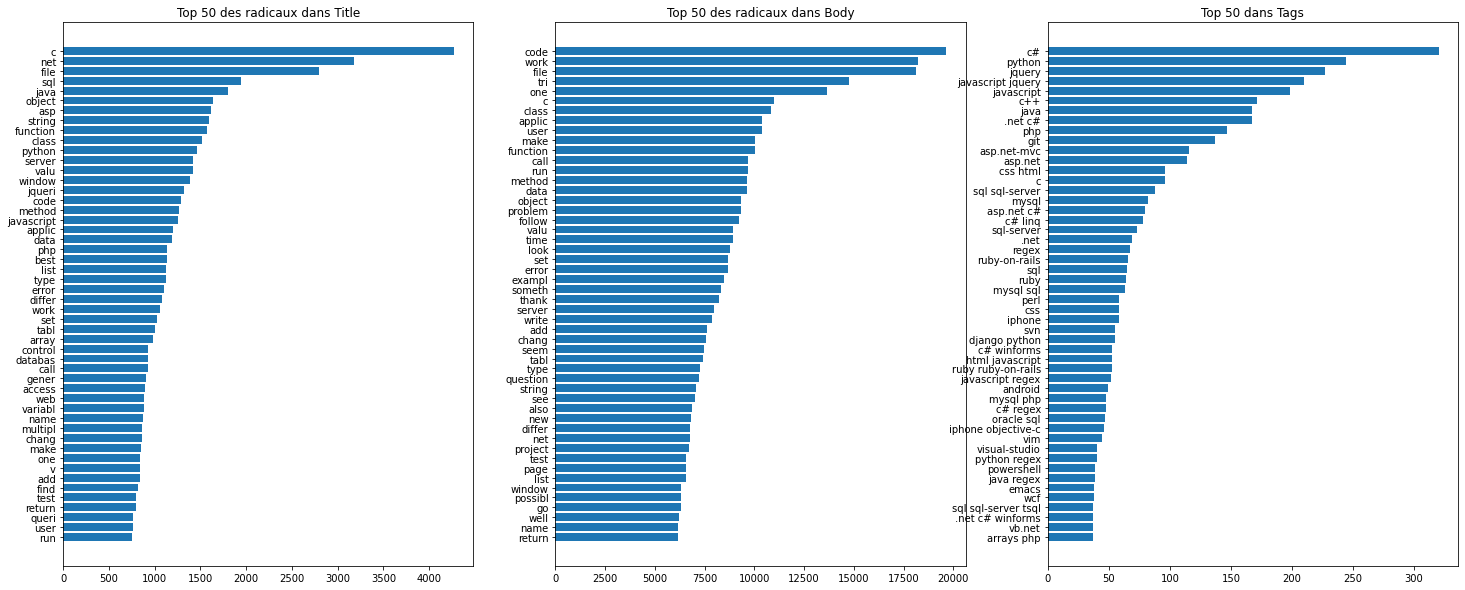

In [ ]:
cpt = 0 
fig = plt.figure(figsize=(25, 10))

for col in cols[:-1]:
    cpt += 1
    plt.subplot(1, 3, cpt)
    plt.barh([k for k, v in sorted(freq[col][:TOP], key=lambda x: x[1])], 
             [v for k, v in sorted(freq[col][:TOP], key=lambda x: x[1])])
    plt.title('Top {} des radicaux dans {}'.format(TOP, col))

temp = train.Tags.value_counts().to_frame('counts')
plt.subplot(133)
plt.barh(temp.sort_values(by='counts', ascending=True)[-TOP:].index, 
         temp.sort_values(by='counts', ascending=True)[-TOP:].counts)
plt.title('Top {} dans Tags'.format(TOP))

## Top Tags

Text(0.5, 1.0, 'Distribution du nombre de tags par question')

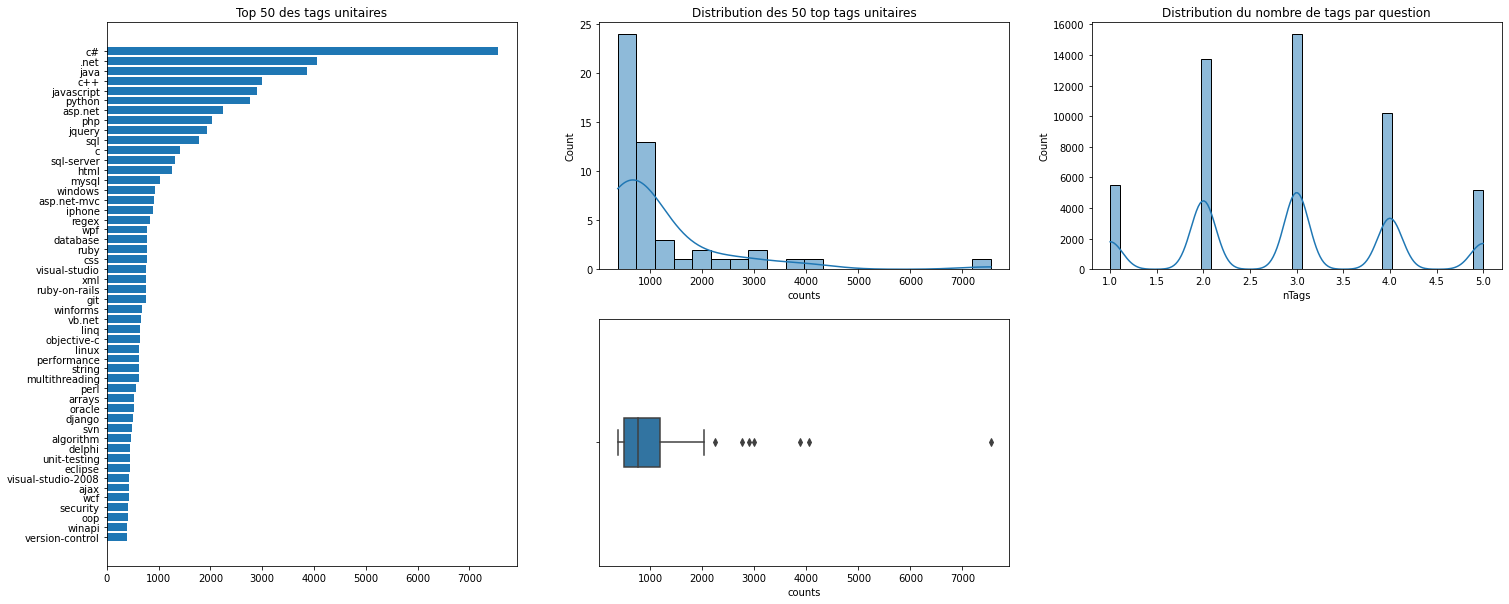

In [ ]:
fig = plt.figure(figsize=(25, 10))
plt.subplot(131)
plt.barh([k for k, v in sorted(freq['Tags'][:TOP], key=lambda x: x[1])], 
         [v for k, v in sorted(freq['Tags'][:TOP], key=lambda x: x[1])])
plt.title('Top {} des tags unitaires'.format(TOP))

temp = pd.DataFrame.from_dict(dict(freq['Tags'][:TOP]), orient='index')\
                              .rename(columns={0:'counts'})
plt.subplot(232)
plt.title('Distribution des {} top tags unitaires'.format(TOP))
sns.histplot(temp.counts, kde=True)

plt.subplot(235)
sns.boxplot(x=temp.counts, width=0.2)

plt.subplot(233)
sns.histplot(train['nTags'], kde=True)
plt.title('Distribution du nombre de tags par question')

In [ ]:
pd.DataFrame(freq['Tags']).rename(columns={0:'Tag', 1:'count'}).describe()

,count
count,10494.000000
mean,13.895941
std,121.763098
min,1.000000
25%,1.000000
50%,2.000000
75%,5.000000
max,7544.000000


In [ ]:
train['Tags_lbl'].value_counts().to_frame().describe()

,Tags_lbl
count,36891.000000
mean,1.355344
std,4.182327
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,320.000000


In [ ]:
fig = plt.figure(figsize=(25, 10))
temp = pd.DataFrame.from_dict(dict(freq['Tags'][:TOP]), orient='index')\
                              .rename(columns={0:'counts'})
plt.subplot(131)
plt.subplot(232)
plt.title('Distribution des {} top tags unitaires'.format(TOP))
sns.histplot(temp.counts, kde=True)

plt.subplot(235)
sns.boxplot(x=temp.counts, width=0.2)

In [ ]:
dict_tags = defaultdict(list)

#temp = train[train.index.isin([169828, 431644, 1450121, 426609, 14646])].copy()
temp = train.copy()

for i, j in temp.iterrows():
    for t in j['Tags'].split():
        if t in dict(freq['Tags'][:100]).keys():
            try:
                dict_tags[t].extend([i])
            except KeyError:
                dict_tags[t] = [i]

for k, v in dict_tags.items():
    chaine = ' '.join(temp[temp.index.isin(v)].Title.values + temp[temp.index.isin(v)].Body.values )
    dict_tags[k] = Counter(chaine.split()).most_common()[:2]

dict_tags

defaultdict(list,
            {'.net': [('net', 3146), ('code', 1849)],
             '.net-3.5': [('net', 231), ('work', 87)],
             'ajax': [('ajax', 691), ('page', 359)],
             'algorithm': [('algorithm', 513), ('number', 268)],
             'android': [('android', 454), ('app', 177)],
             'arrays': [('array', 1479), ('valu', 267)],
             'asp.net': [('net', 2613), ('asp', 2424)],
             'asp.net-mvc': [('mvc', 1222), ('net', 1152)],
             'bash': [('file', 438), ('script', 436)],
             'c': [('c', 2036), ('code', 921)],
             'c#': [('c', 4935), ('code', 4025)],
             'c++': [('c', 3621), ('code', 1738)],
             'class': [('class', 765), ('method', 131)],
             'cocoa': [('object', 155), ('cocoa', 134)],
             'cocoa-touch': [('view', 204), ('iphon', 128)],
             'css': [('cs', 1039), ('div', 459)],
             'database': [('databas', 1282), ('tabl', 989)],
             'database-design': [(

# Réduction du scope
Pour commencer, je considère les questions avec 1 seul tag 

In [ ]:
train_1T = train[train.nTags == 1]
freq = recap_cols(train_1T, cols)
print(train.shape)
train_1T.head()

Dénombrenent des mots
	Title  :   27668 dont   3747 distincts
	Body   :  190725 dont   9809 distincts
	Tags   :    5512 dont    867 distincts
(50000, 4)


,Title,Body,Tags,nTags
14646,add project descript fogbugz,new project even edit sampl project add descri...,fogbugz,1
34017938,decrement valu scheme,procedur find n small prime larg add paramet n...,scheme,1
1023055,sort current point end file gvim,follow command mode gvim result star littl som...,vim,1
2177008,mean rubi,mean rubi,ruby,1
368947,javascript error thrown ajaxtoolkit net machin,button save asynchron ajaxtoolkit c net error ...,.net,1


Réduction aux 50 top tags

Dénombrenent des mots
	Title  :   15180 dont   2316 distincts
	Body   :   97056 dont   6340 distincts
	Tags   :    3009 dont     34 distincts


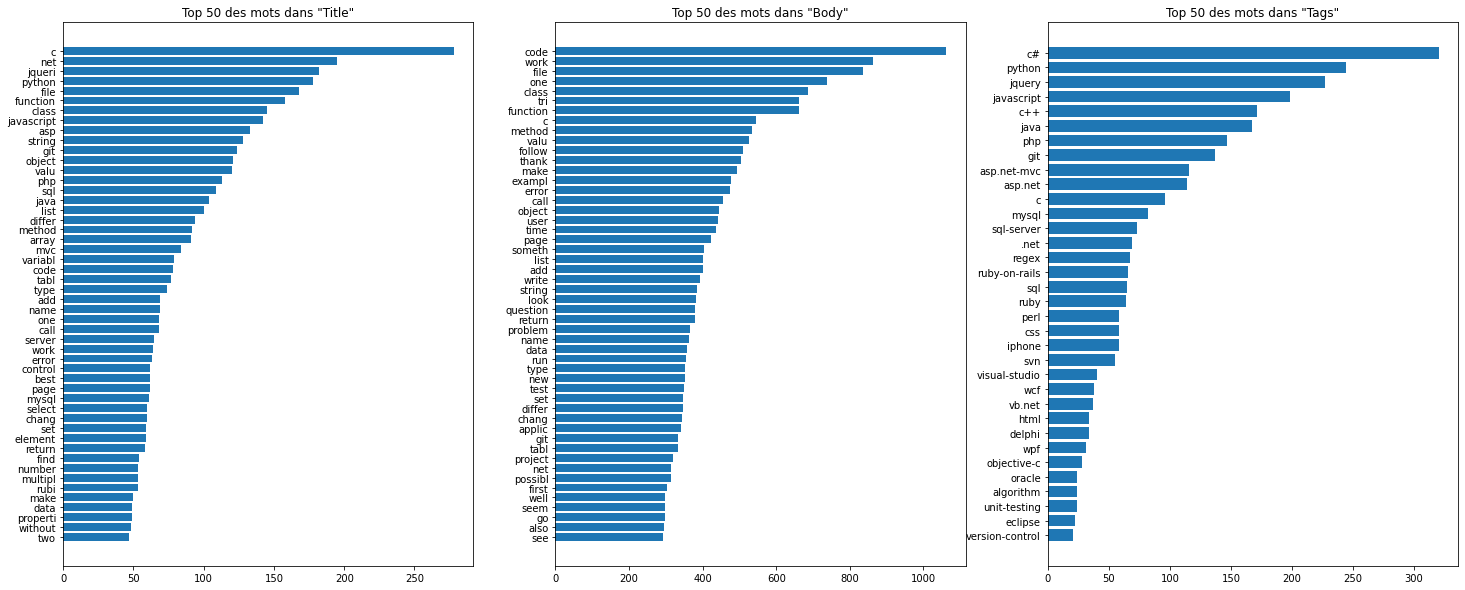

In [ ]:
cpt = 1
train_1T = train_1T[train_1T.Tags.isin(dict(freq['Tags'][:top]).keys())]

freq = recap_cols(train_1T, cols)

fig = plt.figure(1, figsize=(25, 10))

for col in cols:
    plt.subplot(1, len(cols), cpt)
    plt.barh([k for k, v in sorted(freq[col][:top], key=lambda x: x[1])], 
             [v for k, v in sorted(freq[col][:top], key=lambda x: x[1])])
    plt.title('Top {} des mots dans "{}"'.format(top, col))
    cpt += 1 

# TF-IDF Title

In [ ]:
tfidf_vectorizer = TfidfVectorizer(token_pattern=r'\w+')
tfidf_Title_v = tfidf_vectorizer.fit_transform(train['Title'])
feature_names = tfidf_vectorizer.get_feature_names()
tfidf_Title_v.shape

(50000, 12568)

In [ ]:
tfidf_Title = pd.DataFrame(tfidf_Title_v[:1000].todense().tolist(), columns=feature_names, index=train.index[:1000])
tfidf_Title.head()

,aab,aabb,aac,aad,aasm,ab,aba,abab,abac,abandon,abb,abbr,abbrev,abbrevi,abc,abcb,abcd,abcpdf,abil,abl,abnorm,abort,abrupt,absenc,absolut,absorb,abstract,abstractcontrol,abstractli,abstracttablemodel,abus,academ,acc,acceler,acceleromet,accent,accept,acces,access,accesscontrolexcept,...,zaber,zcat,zd,zebra,zedgraph,zehut,zenburn,zend,zendesk,zerigo,zero,zeromq,zeu,zf,zig,zigzag,zinc,zindex,zio,zip,ziparch,zipexcept,zipfil,zipinputstream,zippackag,zlib,zombi,zone,zonelocalmap,zookeep,zoom,zoomabl,zposit,zsh,zulu,zune,zwquerysysteminform,zxjdbc,zygo,zzz
169828,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
431644,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1450121,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
426609,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14646,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
import unidecode
unaccented_string = unidecode.unidecode('â€Žâ€Žu1 totot')
unaccented_string

'aEURZaEURZu1 totot'

In [ ]:
train[train.index == 1455350]

,Title,Body,Tags,nTags,Tags_lbl
1455350,warn access deni user,extrem basic apolog ask rooki question error u...,mysql mysql-error-1045 php,3,33290


In [ ]:
tokenizer = nltk.RegexpTokenizer("\w+") 

In [ ]:
tokenizer.tokenize('c#')

['c']

In [ ]:
toto = unicode('â€Žâ€Žu1')
toto

NameError: ignored

In [ ]:
tfidf_Title[tfidf_Title.index == 2177008].sum().reset_index().sort_values(by=0, ascending=False)

,index,0
1197,mean,0.760171
1736,rubi,0.649723
1545,produc,0.000000
1539,privileg,0.000000
1540,pro,0.000000
...,...,...
772,forbidden,0.000000
773,forc,0.000000
774,foreach,0.000000
775,foreign,0.000000


In [ ]:
train_1T.head()

,Title,Body,Tags,nTags
2177008,mean rubi,mean rubi,ruby,1
368947,javascript error thrown ajaxtoolkit net machin,button save asynchron ajaxtoolkit c net error ...,.net,1
488240,chang checkbox javascript,seri checkbox html page check checkbox base co...,javascript,1
630434,jqueri overwrit click event within click,function call attach click event link locat to...,jquery,1
1087251,simpl html construct asp net,simpl question think put tag asp net app ask m...,asp.net,1


## PCA

In [22]:
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='\w+',  
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(train.Title)
data_vectorized.shape

(50000, 2270)

In [31]:
pca = decomposition.PCA(n_components=2)

X = data_vectorized.todense()

# On scale d’abord les données 
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

X_trans = pca.fit_transform(X_scaled)

print("PCA", len(pca.components_), "composants:", \
      pca.explained_variance_ratio_, pca.explained_variance_ratio_.sum())

PCA 2 composants: [0.00119679 0.0011351 ] 0.0023318905278153917


## Clustering

In [28]:
nb_clusters = 50
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
        for i in range(nb_clusters)]

fig = plt.figure(figsize=(20, 20))

# Puis on applique tSNE aux données scalées :
#tsne = manifold.TSNE(n_components=2, init='pca')
#X_trans = tsne.fit_transform(X_scaled)

# Clustering avec kmeans
myclust = cluster.KMeans(n_clusters=nb_clusters)
myclust.fit(X_scaled)

# Puis on visualise 
for i in range(X.shape[0]): # pour chaque point
    plt.text(X_trans[i, 0], X_trans[i, 1], 
             myclust.labels_[i], color=color[myclust.labels_[i]] ) 
    #plt.cm.Set2(myclust.labels_[i]/10.))

# On redéfinit les axes pour bien voir tous les points
plt.xlim(np.around([np.min(X_trans[:, 0]), np.max(X_trans[:, 0])], decimals=-1))
plt.ylim(np.around([np.min(X_trans[:, 1]), np.max(X_trans[:, 1])], decimals=-1))

# On affiche l'image
plt.show()

# 3. Évaluation
# Pour l’évaluation intrinsèque, je choisis le coefficient de silhouette :
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, myclust.labels_))

KeyboardInterrupt: ignored

<Figure size 1440x1440 with 0 Axes>

In [ ]:
#Create a cluster label column in the original DataFrame
y = myclust.labels_
tfidf = tfidf_Title.assign(cluster = y)
tfidf.groupby(['cluster'])[['cluster']].count().T.reset_index(drop=True)

cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,1,7,1,51,1,1,1,1,1,31,1,47,1,45,20,163,1,1,1,1,1,1,7,45,6,1,2886,1,1,7,1,1,1,1,1,1,1,1,1,1,88,1,1,1,2,1,41,1,1,1


## Classification supervisée

In [ ]:
lbl = LabelEncoder()

lbl_tag = lbl.fit_transform(train_1T.Tags)

X_train, X_test, y_train, y_test = train_test_split(tfidf_Title, lbl_tag, test_size=0.3)

std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = std_scale.transform(X_train)
X_test_scaled = std_scale.transform(X_test)
X_train_scaled.shape, X_test_scaled.shape

((2436, 2538), (1045, 2538))

accuracy 65.00% time 3.14s

Confusion matrix, without normalization


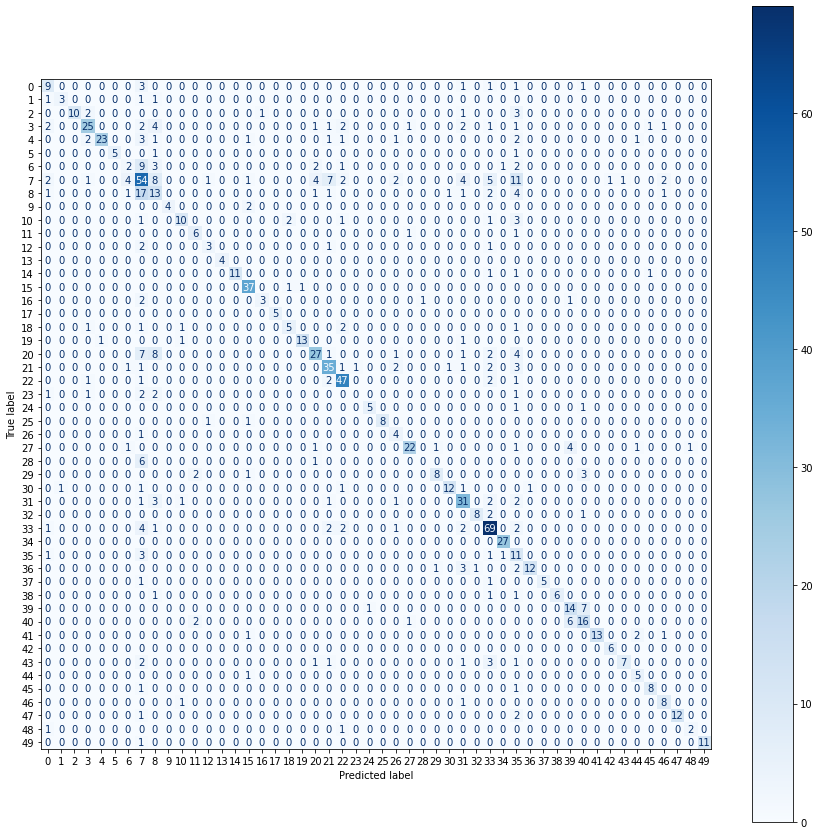

Normalized confusion matrix


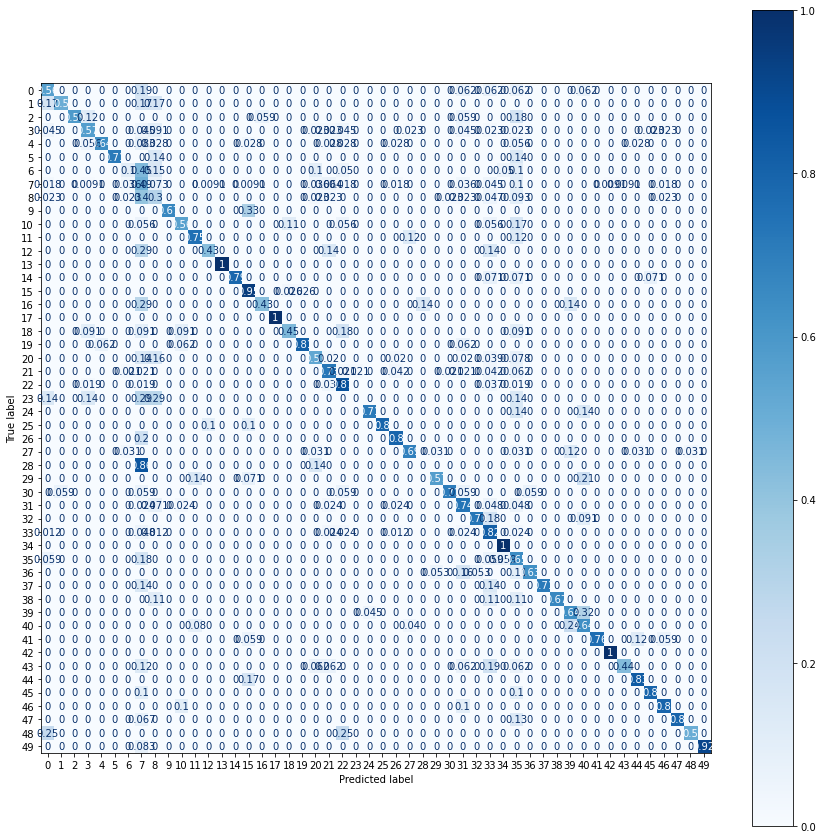

In [ ]:
gs = RandomForestClassifier()

start_time = timeit.default_timer()

gs.fit(X_train_scaled, y_train)
y_pred = gs.predict(X_test_scaled)

elapsed = timeit.default_timer() - start_time

accuracy = 100*metrics.accuracy_score(y_test, y_pred).round(2)
print("accuracy {:.2f}% time {:.2f}s\n".format(accuracy, elapsed))

np.set_printoptions(precision=2)

#plt.figure(figsize=(20, 20))
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                    ("Normalized confusion matrix", 'true')]
cpt = 1 
for title, normalize in titles_options:
    fig, ax = plt.subplots(figsize=(15, 15))
    metrics.plot_confusion_matrix(gs, X_test_scaled, y_test, \
                                  # display_labels=class_names, 
                                  cmap=plt.cm.Blues, \
                                  normalize=normalize, ax=ax)
    #ax_.set_title(title)

    print(title)
    #print(disp.confusion_matrix)
    plt.show()
    cpt += 1 

## Focus Body

In [ ]:
from unidecode import unidecode

In [ ]:
train_1T['Body'] = train_1T['Body'].apply(unidecode)

In [ ]:
tfidf_Body_v = tfidf_vectorizer.fit_transform(train_1T['Body'])
feature_names = tfidf_vectorizer.get_feature_names()

tfidf_Body = pd.DataFrame(tfidf_Body_v.todense().tolist(), columns=feature_names, index=train_1T.index)
tfidf_Body.head()

,a,ab,abandon,abbrevi,abbyy,abc,abcd,abcdefghi,abil,abl,abnorm,abort,aboutm,abovement,absenc,absolut,abstract,absurd,abt,abus,ac,academ,academi,acccess,accdb,accent,accept,acces,access,accessor,accid,accident,accommod,accompani,accomplish,accord,accordingli,account,accountcontrol,accountmanag,...,xxxxxxxxxx,y,ya,yaaq,yahoo,yahtze,yaml,yank,yay,ye,yeah,year,yearli,yellow,yesterday,yet,yield,yike,yolk,york,young,youtub,yu,yy,zc,zed,zehut,zeppelin,zero,zf,zi,zijab,zip,ziparch,zone,zoom,zope,zqw,zsh,zubair
1023055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2177008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
368947,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.072926,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
488240,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
630434,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
'ß'.isalpha()

True

In [ ]:
tfidf_Title[tfidf_Title.index == 2177008].sum().reset_index().sort_values(by=0, ascending=False)

,index,0
1311,mean,0.750079
1904,rubi,0.661349
1695,pro,0.000000
1688,primit,0.000000
1689,princip,0.000000
...,...,...
847,fork,0.000000
848,forloop,0.000000
849,form,0.000000
850,format,0.000000


In [ ]:
train_1T.head()

,Title,Body,Tags,nTags
1023055,sort current point end file gvim,follow command mode gvim result star littl som...,vim,1
2177008,mean rubi,mean rubi,ruby,1
368947,javascript error thrown ajaxtoolkit net machin,button save asynchron ajaxtoolkit c net error ...,.net,1
488240,chang checkbox javascript,seri checkbox html page check checkbox base co...,javascript,1
630434,jqueri overwrit click event within click,function call attach click event link locat to...,jquery,1


PCA

In [ ]:
pca = decomposition.PCA(n_components=2)

X = tfidf_Body.values

# On scale d’abord les données 
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

X_trans = pca.fit_transform(X_scaled)

print("PCA", len(pca.components_), "composants:", \
      pca.explained_variance_ratio_, pca.explained_variance_ratio_.sum())

PCA 2 composants: [0. 0.] 0.0036313742918188284


Clustering

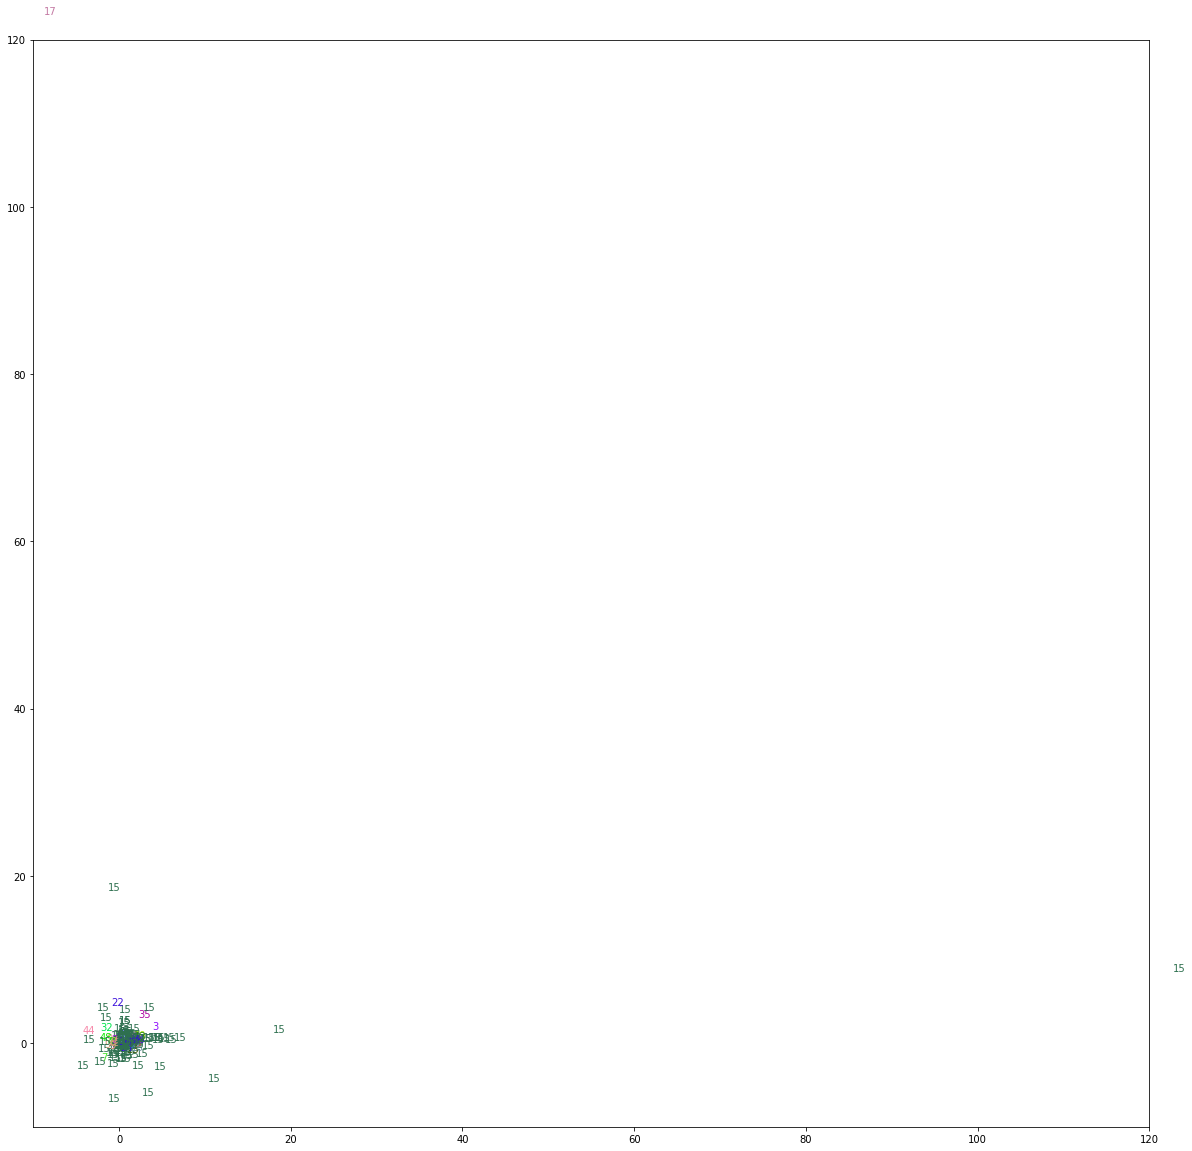

Silhouette Coefficient: -0.041


In [ ]:
nb_clusters = 50
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
        for i in range(nb_clusters)]

fig = plt.figure(figsize=(20, 20))

# Puis on applique tSNE aux données scalées :
#tsne = manifold.TSNE(n_components=2, init='pca')
#X_trans = tsne.fit_transform(X_scaled)

# Clustering avec kmeans
myclust = cluster.KMeans(n_clusters=nb_clusters)
myclust.fit(X_scaled)

# Puis on visualise, selon la méthode donnée dans le coup de pouce :
for i in range(X.shape[0]): # pour chaque point
    plt.text(X_trans[i, 0], X_trans[i, 1], 
             myclust.labels_[i], color=color[myclust.labels_[i]] ) 
    #plt.cm.Set2(myclust.labels_[i]/10.))

# On redéfinit les axes pour bien voir tous les points
plt.xlim(np.around([np.min(X_trans[:, 0]), np.max(X_trans[:, 0])], decimals=-1))
plt.ylim(np.around([np.min(X_trans[:, 1]), np.max(X_trans[:, 1])], decimals=-1))

# On affiche l'image
plt.show()

# 3. Évaluation
# Pour l’évaluation intrinsèque, je choisis le coefficient de silhouette :
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, myclust.labels_))

In [ ]:
#Create a cluster label column in the original DataFrame
y = myclust.labels_
tfidf = tfidf_Title.assign(cluster = y)
tfidf.groupby(['cluster'])[['cluster']].count().T.reset_index(drop=True)

cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,3,10,43,1,1,1,1,1,1,38,12,1,1,1,8,2914,1,1,1,1,1,1,1,1,329,1,1,1,1,1,1,1,1,1,64,1,1,1,1,1,1,1,1,1,1,1,1,1,20,1


Classification supervisée

In [ ]:
lbl = LabelEncoder()

lbl_tag = lbl.fit_transform(train_1T.Tags)

X_train, X_test, y_train, y_test = train_test_split(tfidf_Body, lbl_tag, test_size=0.3)

std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = std_scale.transform(X_train)
X_test_scaled = std_scale.transform(X_test)
X_train_scaled.shape, X_test_scaled.shape

((2436, 7045), (1045, 7045))

accuracy 64.00% time 3.30s

Confusion matrix, without normalization


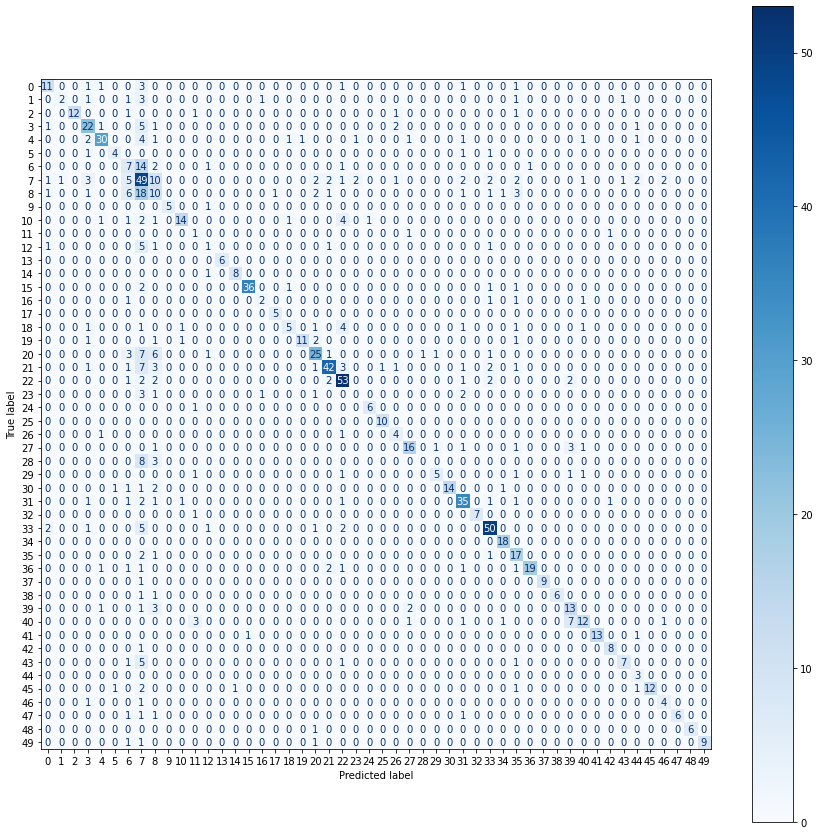

Normalized confusion matrix


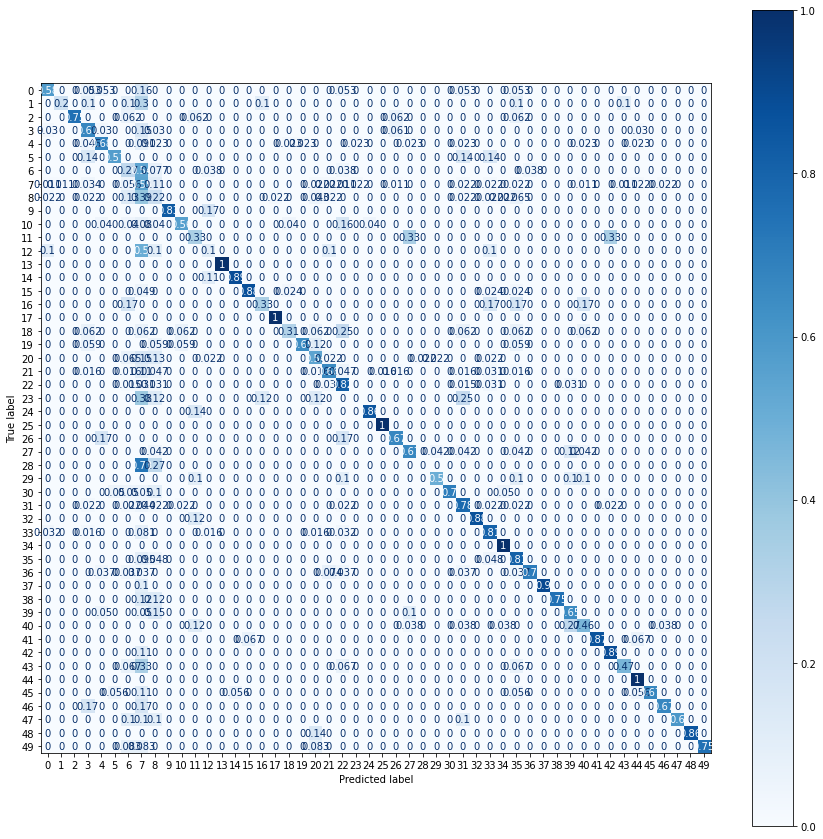

In [ ]:
gs = RandomForestClassifier()

start_time = timeit.default_timer()

gs.fit(X_train_scaled, y_train)
y_pred = gs.predict(X_test_scaled)

elapsed = timeit.default_timer() - start_time

accuracy = 100*metrics.accuracy_score(y_test, y_pred).round(2)
print("accuracy {:.2f}% time {:.2f}s\n".format(accuracy, elapsed))

np.set_printoptions(precision=2)

#plt.figure(figsize=(20, 20))
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                    ("Normalized confusion matrix", 'true')]
cpt = 1 
for title, normalize in titles_options:
    fig, ax = plt.subplots(figsize=(15, 15))
    metrics.plot_confusion_matrix(gs, X_test_scaled, y_test, \
                                  # display_labels=class_names, 
                                  cmap=plt.cm.Blues, \
                                  normalize=normalize, ax=ax)
    #ax_.set_title(title)

    print(title)
    #print(disp.confusion_matrix)
    plt.show()
    cpt += 1 

# TF-IDF new

In [ ]:
tfidf_vectorizer = TfidfVectorizer(token_pattern=r'\w+')

NameError: ignored

## Focus Title

In [ ]:
tfidf_Title_v = tfidf_vectorizer.fit_transform(train['Title'])
feature_names = tfidf_vectorizer.get_feature_names()

tfidf_Title = pd.DataFrame(tfidf_Title_v.todense().tolist(), columns=feature_names, index=train.index)
tfidf_Title.head()

NameError: ignored

In [ ]:
tfidf_Title[tfidf_Title.index == 2177008].sum().reset_index().sort_values(by=0, ascending=False)

,index,0
1197,mean,0.760171
1736,rubi,0.649723
1545,produc,0.000000
1539,privileg,0.000000
1540,pro,0.000000
...,...,...
772,forbidden,0.000000
773,forc,0.000000
774,foreach,0.000000
775,foreign,0.000000


In [ ]:
train_1T.head()

,Title,Body,Tags,nTags
2177008,mean rubi,mean rubi,ruby,1
368947,javascript error thrown ajaxtoolkit net machin,button save asynchron ajaxtoolkit c net error ...,.net,1
488240,chang checkbox javascript,seri checkbox html page check checkbox base co...,javascript,1
630434,jqueri overwrit click event within click,function call attach click event link locat to...,jquery,1
1087251,simpl html construct asp net,simpl question think put tag asp net app ask m...,asp.net,1


### PCA

In [ ]:
pca = decomposition.PCA(n_components=2)

X = tfidf_Title.values

# On scale d’abord les données 
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

X_trans = pca.fit_transform(X_scaled)

print("PCA", len(pca.components_), "composants:", \
      pca.explained_variance_ratio_, pca.explained_variance_ratio_.sum())

PCA 2 composants: [0.00215878 0.00198559] 0.004144369675533617


### Clustering

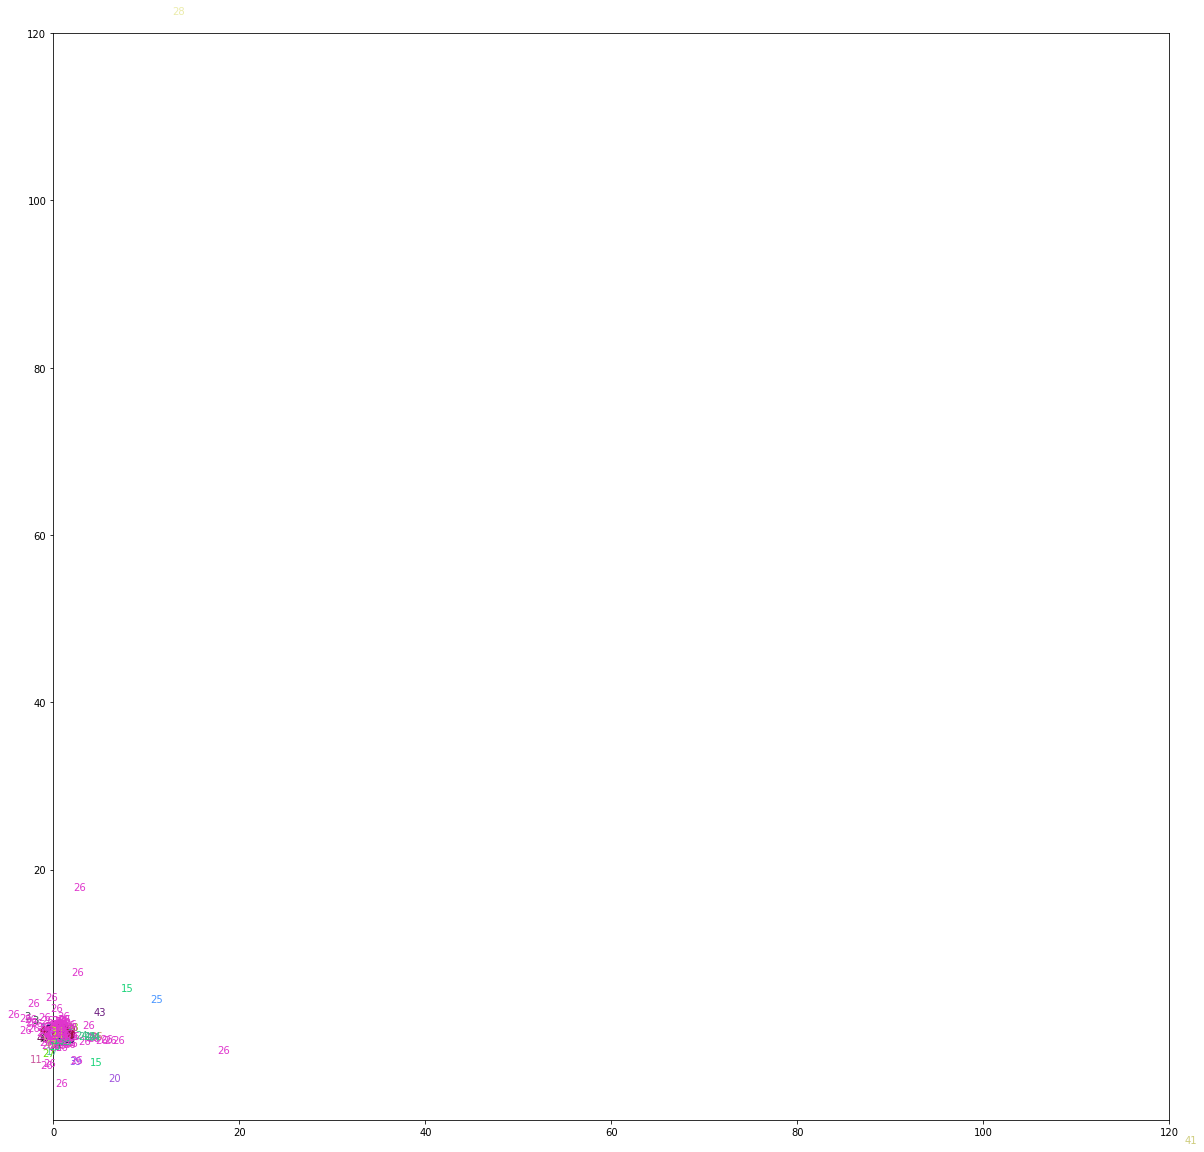

Silhouette Coefficient: -0.039


In [ ]:
nb_clusters = 50
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
        for i in range(nb_clusters)]

fig = plt.figure(figsize=(20, 20))

# Puis on applique tSNE aux données scalées :
#tsne = manifold.TSNE(n_components=2, init='pca')
#X_trans = tsne.fit_transform(X_scaled)

# Clustering avec kmeans
myclust = cluster.KMeans(n_clusters=nb_clusters)
myclust.fit(X_scaled)

# Puis on visualise 
for i in range(X.shape[0]): # pour chaque point
    plt.text(X_trans[i, 0], X_trans[i, 1], 
             myclust.labels_[i], color=color[myclust.labels_[i]] ) 
    #plt.cm.Set2(myclust.labels_[i]/10.))

# On redéfinit les axes pour bien voir tous les points
plt.xlim(np.around([np.min(X_trans[:, 0]), np.max(X_trans[:, 0])], decimals=-1))
plt.ylim(np.around([np.min(X_trans[:, 1]), np.max(X_trans[:, 1])], decimals=-1))

# On affiche l'image
plt.show()

# 3. Évaluation
# Pour l’évaluation intrinsèque, je choisis le coefficient de silhouette :
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, myclust.labels_))

In [ ]:
#Create a cluster label column in the original DataFrame
y = myclust.labels_
tfidf = tfidf_Title.assign(cluster = y)
tfidf.groupby(['cluster'])[['cluster']].count().T.reset_index(drop=True)

cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,1,7,1,51,1,1,1,1,1,31,1,47,1,45,20,163,1,1,1,1,1,1,7,45,6,1,2886,1,1,7,1,1,1,1,1,1,1,1,1,1,88,1,1,1,2,1,41,1,1,1


### Classification supervisée

In [ ]:
lbl = LabelEncoder()

lbl_tag = lbl.fit_transform(train_1T.Tags)

X_train, X_test, y_train, y_test = train_test_split(tfidf_Title, lbl_tag, test_size=0.3)

std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = std_scale.transform(X_train)
X_test_scaled = std_scale.transform(X_test)
X_train_scaled.shape, X_test_scaled.shape

((2436, 2538), (1045, 2538))

accuracy 65.00% time 3.14s

Confusion matrix, without normalization


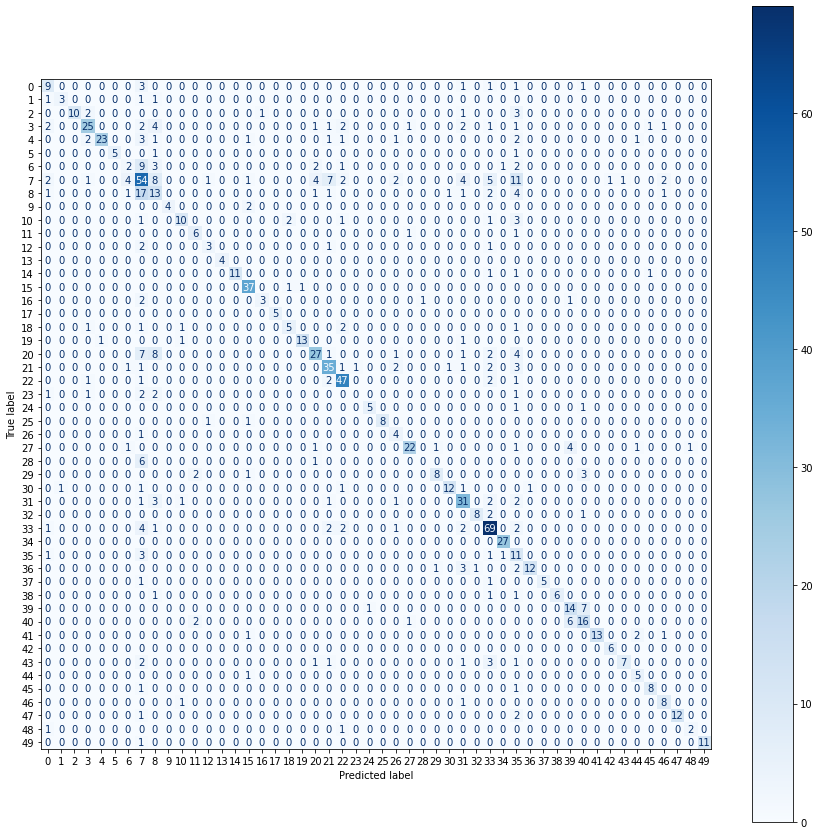

Normalized confusion matrix


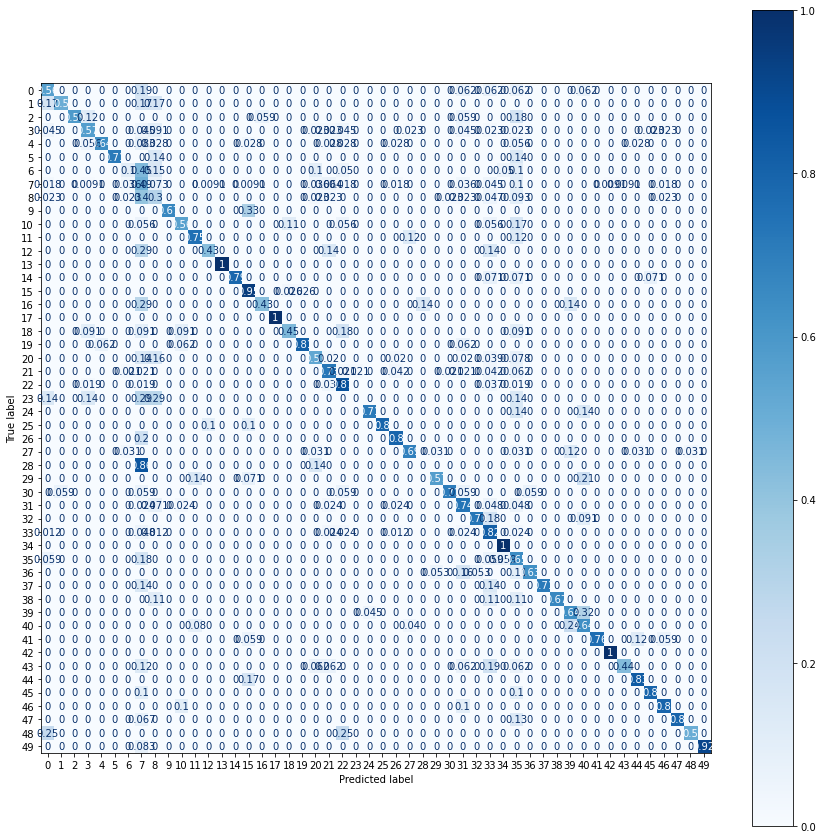

In [ ]:
gs = RandomForestClassifier()

start_time = timeit.default_timer()

gs.fit(X_train_scaled, y_train)
y_pred = gs.predict(X_test_scaled)

elapsed = timeit.default_timer() - start_time

accuracy = 100*metrics.accuracy_score(y_test, y_pred).round(2)
print("accuracy {:.2f}% time {:.2f}s\n".format(accuracy, elapsed))

np.set_printoptions(precision=2)

#plt.figure(figsize=(20, 20))
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                    ("Normalized confusion matrix", 'true')]
cpt = 1 
for title, normalize in titles_options:
    fig, ax = plt.subplots(figsize=(15, 15))
    metrics.plot_confusion_matrix(gs, X_test_scaled, y_test, \
                                  # display_labels=class_names, 
                                  cmap=plt.cm.Blues, \
                                  normalize=normalize, ax=ax)
    #ax_.set_title(title)

    print(title)
    #print(disp.confusion_matrix)
    plt.show()
    cpt += 1 

## Focus Body

In [ ]:
from unidecode import unidecode

In [ ]:
train_1T['Body'] = train_1T['Body'].apply(unidecode)

In [ ]:
tfidf_Body_v = tfidf_vectorizer.fit_transform(train_1T['Body'])
feature_names = tfidf_vectorizer.get_feature_names()

tfidf_Body = pd.DataFrame(tfidf_Body_v.todense().tolist(), columns=feature_names, index=train_1T.index)
tfidf_Body.head()

,a,ab,abandon,abbrevi,abbyy,abc,abcd,abcdefghi,abil,abl,abnorm,abort,aboutm,abovement,absenc,absolut,abstract,absurd,abt,abus,ac,academ,academi,acccess,accdb,accent,accept,acces,access,accessor,accid,accident,accommod,accompani,accomplish,accord,accordingli,account,accountcontrol,accountmanag,...,xxxxxxxxxx,y,ya,yaaq,yahoo,yahtze,yaml,yank,yay,ye,yeah,year,yearli,yellow,yesterday,yet,yield,yike,yolk,york,young,youtub,yu,yy,zc,zed,zehut,zeppelin,zero,zf,zi,zijab,zip,ziparch,zone,zoom,zope,zqw,zsh,zubair
1023055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2177008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
368947,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.072926,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
488240,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
630434,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
'ß'.isalpha()

True

In [ ]:
tfidf_Title[tfidf_Title.index == 2177008].sum().reset_index().sort_values(by=0, ascending=False)

,index,0
1311,mean,0.750079
1904,rubi,0.661349
1695,pro,0.000000
1688,primit,0.000000
1689,princip,0.000000
...,...,...
847,fork,0.000000
848,forloop,0.000000
849,form,0.000000
850,format,0.000000


In [ ]:
train_1T.head()

,Title,Body,Tags,nTags
1023055,sort current point end file gvim,follow command mode gvim result star littl som...,vim,1
2177008,mean rubi,mean rubi,ruby,1
368947,javascript error thrown ajaxtoolkit net machin,button save asynchron ajaxtoolkit c net error ...,.net,1
488240,chang checkbox javascript,seri checkbox html page check checkbox base co...,javascript,1
630434,jqueri overwrit click event within click,function call attach click event link locat to...,jquery,1


PCA

In [ ]:
pca = decomposition.PCA(n_components=2)

X = tfidf_Body.values

# On scale d’abord les données 
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

X_trans = pca.fit_transform(X_scaled)

print("PCA", len(pca.components_), "composants:", \
      pca.explained_variance_ratio_, pca.explained_variance_ratio_.sum())

PCA 2 composants: [0. 0.] 0.0036313742918188284


Clustering

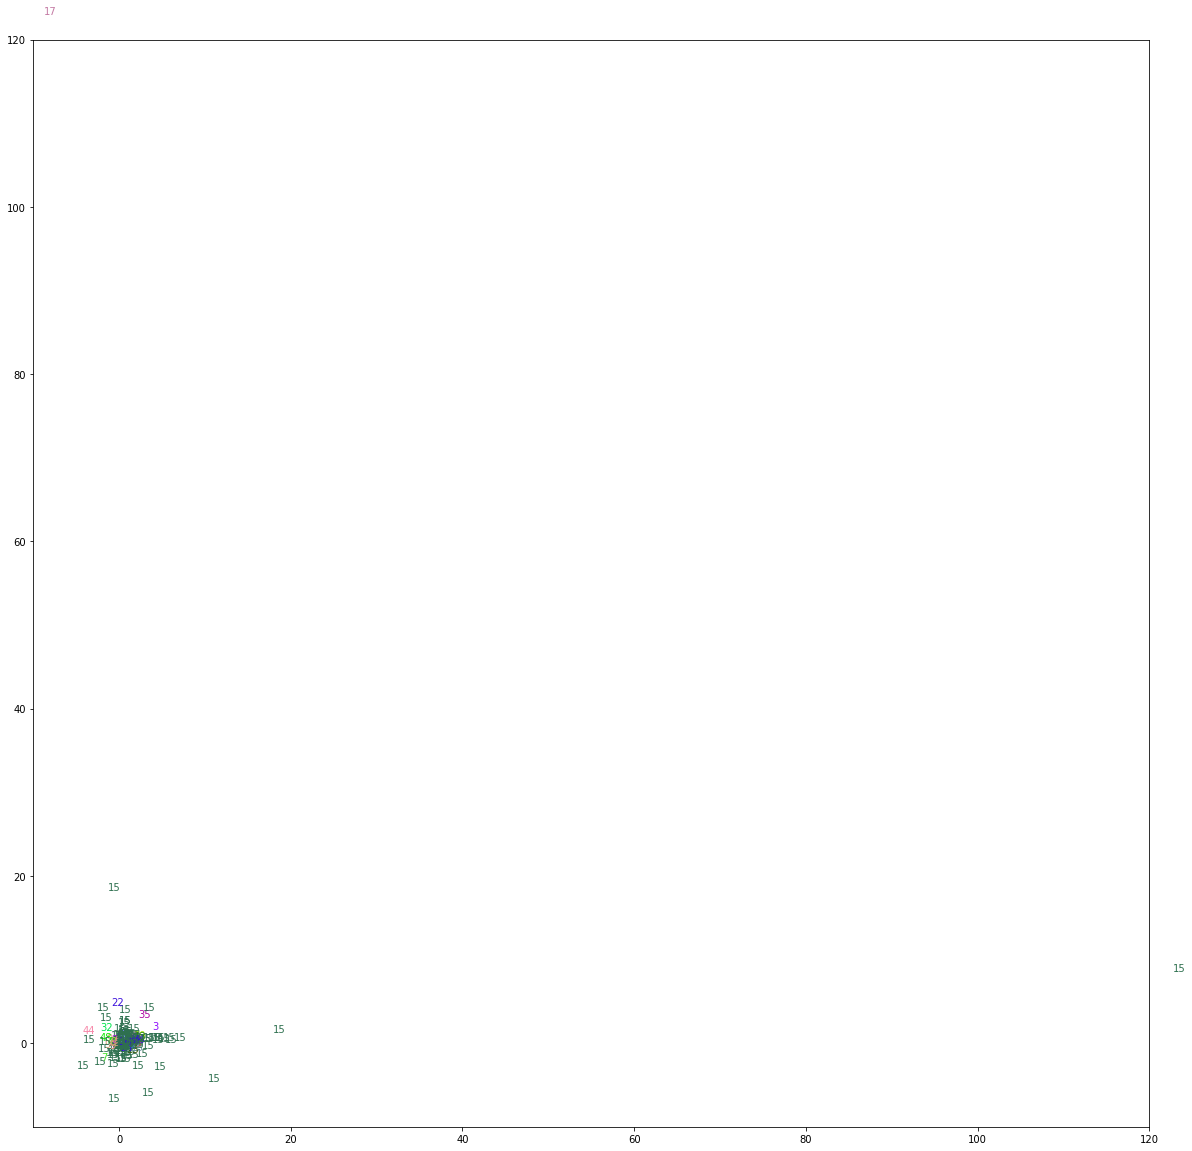

Silhouette Coefficient: -0.041


In [ ]:
nb_clusters = 50
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
        for i in range(nb_clusters)]

fig = plt.figure(figsize=(20, 20))

# Puis on applique tSNE aux données scalées :
#tsne = manifold.TSNE(n_components=2, init='pca')
#X_trans = tsne.fit_transform(X_scaled)

# Clustering avec kmeans
myclust = cluster.KMeans(n_clusters=nb_clusters)
myclust.fit(X_scaled)

# Puis on visualise, selon la méthode donnée dans le coup de pouce :
for i in range(X.shape[0]): # pour chaque point
    plt.text(X_trans[i, 0], X_trans[i, 1], 
             myclust.labels_[i], color=color[myclust.labels_[i]] ) 
    #plt.cm.Set2(myclust.labels_[i]/10.))

# On redéfinit les axes pour bien voir tous les points
plt.xlim(np.around([np.min(X_trans[:, 0]), np.max(X_trans[:, 0])], decimals=-1))
plt.ylim(np.around([np.min(X_trans[:, 1]), np.max(X_trans[:, 1])], decimals=-1))

# On affiche l'image
plt.show()

# 3. Évaluation
# Pour l’évaluation intrinsèque, je choisis le coefficient de silhouette :
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, myclust.labels_))

In [ ]:
#Create a cluster label column in the original DataFrame
y = myclust.labels_
tfidf = tfidf_Title.assign(cluster = y)
tfidf.groupby(['cluster'])[['cluster']].count().T.reset_index(drop=True)

cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,3,10,43,1,1,1,1,1,1,38,12,1,1,1,8,2914,1,1,1,1,1,1,1,1,329,1,1,1,1,1,1,1,1,1,64,1,1,1,1,1,1,1,1,1,1,1,1,1,20,1


Classification supervisée

In [ ]:
lbl = LabelEncoder()

lbl_tag = lbl.fit_transform(train_1T.Tags)

X_train, X_test, y_train, y_test = train_test_split(tfidf_Body, lbl_tag, test_size=0.3)

std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = std_scale.transform(X_train)
X_test_scaled = std_scale.transform(X_test)
X_train_scaled.shape, X_test_scaled.shape

((2436, 7045), (1045, 7045))

accuracy 64.00% time 3.30s

Confusion matrix, without normalization


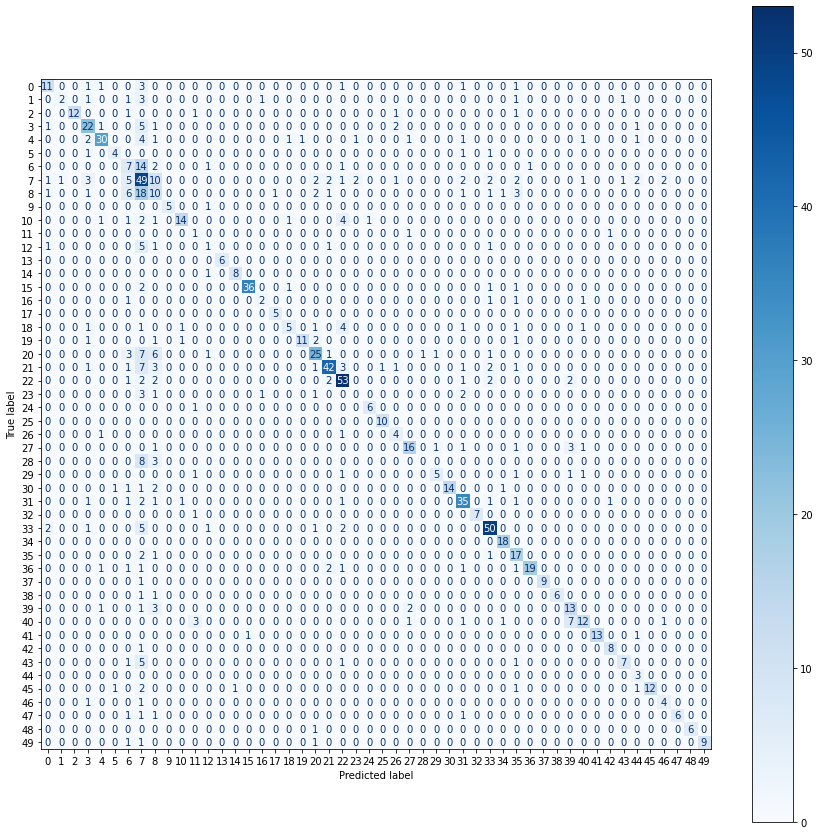

Normalized confusion matrix


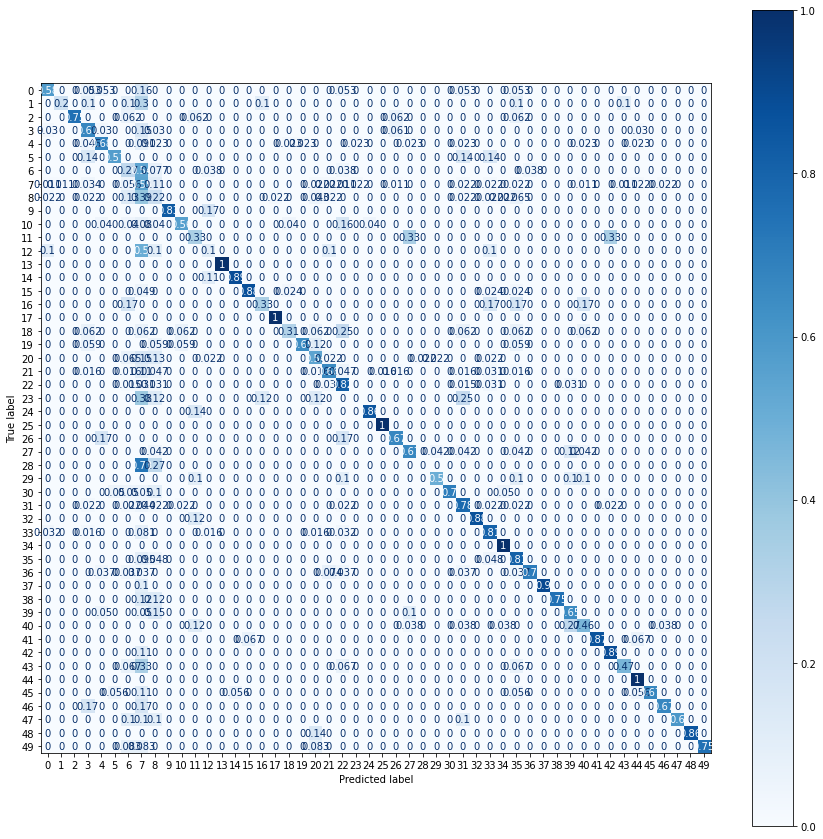

In [ ]:
gs = RandomForestClassifier()

start_time = timeit.default_timer()

gs.fit(X_train_scaled, y_train)
y_pred = gs.predict(X_test_scaled)

elapsed = timeit.default_timer() - start_time

accuracy = 100*metrics.accuracy_score(y_test, y_pred).round(2)
print("accuracy {:.2f}% time {:.2f}s\n".format(accuracy, elapsed))

np.set_printoptions(precision=2)

#plt.figure(figsize=(20, 20))
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                    ("Normalized confusion matrix", 'true')]
cpt = 1 
for title, normalize in titles_options:
    fig, ax = plt.subplots(figsize=(15, 15))
    metrics.plot_confusion_matrix(gs, X_test_scaled, y_test, \
                                  # display_labels=class_names, 
                                  cmap=plt.cm.Blues, \
                                  normalize=normalize, ax=ax)
    #ax_.set_title(title)

    print(title)
    #print(disp.confusion_matrix)
    plt.show()
    cpt += 1 

# LDA

In [ ]:
#instantiate CountVectorizer() 
cv=CountVectorizer() 
 
# this steps generates word counts for the words in your docs 
TF_Title=cv.fit_transform(train_1T.Title)

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
n_topics = 50

# Créer le modèle LDA
lda = LatentDirichletAllocation(
        n_components=n_topics, 
        max_iter=5, 
        learning_method='online', 
        learning_offset=50.,
        random_state=0)

# Fitter sur les données
lda.fit(TF_Title)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=50.0,
                          max_doc_update_iter=100, max_iter=5,
                          mean_change_tol=0.001, n_components=50, n_jobs=None,
                          perp_tol=0.1, random_state=0, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [ ]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, tfidf.columns[:-1], no_top_words)

Topic 0:
tripl ror printf statu newcom integr rule megabyt tail cart
Topic 1:
getrespons shadow fnc comprehens proper protect raw multipli fieldnam namespac
Topic 2:
euler compareto transit dst arraylist mozilla isv updat loop stringparam
Topic 3:
watch collaps system freelanc seri grandpar significantli recommend optimis winform
Topic 4:
verticalalign stringbuild procedur verbos input cocoa round look dealloc erb
Topic 5:
mercuri roll cl default smoothli mixin multipl other roundup eula
Topic 6:
android worker tamper placeholderpagetitleintitlearea collect signific miss version back somefunc
Topic 7:
name asp multi resourc applic eval vb continu valueof action
Topic 8:
teach ifoo reload commun dimension drive initialzi enablecontrol layer trigger
Topic 9:
storabl isv array chanukah besid perform overkil host nativ concret
Topic 10:
jre execut urg overwrit dialogprefer cr usag dialog preprocessor scrap
Topic 11:
screenshot javascript cheat riddl urg squash onto hundr firebug ispostback